In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [3]:
#pip install accelerate -U

In [4]:
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score,  # For F1 score
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    precision_score,
    recall_score
)
import seaborn as sns
# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler # import RandomOverSampler
import accelerate # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [6]:
%cd "../140k"

c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project\140k


In [7]:
import os
train_fake = len(os.listdir("images/train/fake"))
train_real = len(os.listdir("images/train/real"))
test_fake = len(os.listdir("images/test/fake"))
test_real = len(os.listdir("images/test/real"))
val_fake = len(os.listdir("images/valid/fake"))
val_real = len(os.listdir("images/valid/real"))

assert(train_fake == train_real)
assert(test_fake == test_real)
assert(val_fake == val_real)

print("Train total: ", train_fake + train_real)
print("Test total: ", test_fake + test_real)
print("Val total: ", val_fake + val_real)

Train total:  100000
Test total:  20000
Val total:  20000


In [8]:
# Need to create train, test, val

import os
import pandas as pd

# Get the number of fake and real images in each directory
train_fake = len(os.listdir("images/train/fake"))
train_real = len(os.listdir("images/train/real"))
test_fake = len(os.listdir("images/test/fake"))
test_real = len(os.listdir("images/test/real"))
val_fake = len(os.listdir("images/valid/fake"))
val_real = len(os.listdir("images/valid/real"))

# Check that the number of fake and real images is the same for each dataset
assert(train_fake == train_real)
assert(test_fake == test_real)
assert(val_fake == val_real)

# Create dataframes for train, test, and validation data
train_data = pd.DataFrame({
    'image_path': [os.path.join("images/train/fake", img) for img in os.listdir("images/train/fake")] +
                  [os.path.join("images/train/real", img) for img in os.listdir("images/train/real")],
    'label': ['fake'] * train_fake + ['real'] * train_real
})

test_data = pd.DataFrame({
    'image_path': [os.path.join("images/test/fake", img) for img in os.listdir("images/test/fake")] +
                  [os.path.join("images/test/real", img) for img in os.listdir("images/test/real")],
    'label': ['fake'] * test_fake + ['real'] * test_real
})

val_data = pd.DataFrame({
    'image_path': [os.path.join("images/valid/fake", img) for img in os.listdir("images/valid/fake")] +
                  [os.path.join("images/valid/real", img) for img in os.listdir("images/valid/real")],
    'label': ['fake'] * val_fake + ['real'] * val_real
})

# Display total number of images in each dataset
print("Train total: ", len(train_data))
print("Test total: ", len(test_data))
print("Val total: ", len(val_data))


Train total:  100000
Test total:  20000
Val total:  20000


In [9]:
# Create a dataset from a Pandas DataFrame.
# dataset = Dataset.from_pandas(df).cast_column("image", Image())
train_data = Dataset.from_pandas(train_data).cast_column("image_path", Image())
test_data = Dataset.from_pandas(test_data).cast_column("image_path", Image())
val_data = Dataset.from_pandas(val_data).cast_column("image_path", Image())

In [10]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['real', 'fake'] # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'real', 1: 'fake'} 

Mapping of Labels to IDs: {'real': 0, 'fake': 1}


In [11]:
# Creating classlabels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

# Mapping IDs to labels
train_data = train_data.map(map_label2id, batched=True)
test_data = test_data.map(map_label2id, batched=True)
val_data = val_data.map(map_label2id, batched=True)


# Casting label column to ClassLabel Object
train_data = train_data.cast_column('label', ClassLabels)
test_data = test_data.cast_column('label', ClassLabels)
val_data = val_data.cast_column('label', ClassLabels)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Casting the dataset: 100%|██████████| 20000/20000 [00:00<00:00, 5485618.62 examples/s]


In [12]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples

Size:  224


In [13]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

val_data.set_transform(val_transforms)
# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)



In [14]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example['label'] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.to(device)

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [16]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

In [17]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 10

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./10k_ViT_logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
)

In [18]:
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [16]:
# Start training the model using the trainer object.
trainer.train()

  0%|          | 0/31250 [00:00<?, ?it/s]

  2%|▏         | 500/31250 [09:55<10:17:41,  1.21s/it]

{'loss': 0.9493, 'grad_norm': 4.2592363357543945, 'learning_rate': 9.85576923076923e-07, 'epoch': 0.16}


  3%|▎         | 1000/31250 [20:00<10:13:40,  1.22s/it]

{'loss': 0.4791, 'grad_norm': 5.401947021484375, 'learning_rate': 9.69551282051282e-07, 'epoch': 0.32}


  5%|▍         | 1500/31250 [30:04<10:00:37,  1.21s/it]

{'loss': 0.3879, 'grad_norm': 5.277035713195801, 'learning_rate': 9.535256410256411e-07, 'epoch': 0.48}


  6%|▋         | 2000/31250 [40:06<9:41:19,  1.19s/it] 

{'loss': 0.326, 'grad_norm': 9.053318977355957, 'learning_rate': 9.374999999999999e-07, 'epoch': 0.64}


  8%|▊         | 2500/31250 [50:14<10:27:51,  1.31s/it]

{'loss': 0.2864, 'grad_norm': 6.750182151794434, 'learning_rate': 9.214743589743589e-07, 'epoch': 0.8}


 10%|▉         | 3000/31250 [1:00:16<9:42:22,  1.24s/it] 

{'loss': 0.2557, 'grad_norm': 8.357843399047852, 'learning_rate': 9.054487179487179e-07, 'epoch': 0.96}


                                                         
 10%|█         | 3125/31250 [1:08:39<8:49:39,  1.13s/it]

{'eval_loss': 0.27076640725135803, 'eval_accuracy': 0.88625, 'eval_runtime': 351.7492, 'eval_samples_per_second': 56.859, 'eval_steps_per_second': 7.107, 'epoch': 1.0}


 11%|█         | 3500/31250 [1:16:14<10:10:28,  1.32s/it]  

{'loss': 0.2297, 'grad_norm': 3.2402546405792236, 'learning_rate': 8.894230769230768e-07, 'epoch': 1.12}


 13%|█▎        | 4000/31250 [1:26:19<8:55:46,  1.18s/it] 

{'loss': 0.2065, 'grad_norm': 5.224357604980469, 'learning_rate': 8.733974358974358e-07, 'epoch': 1.28}


 14%|█▍        | 4500/31250 [1:36:11<8:42:17,  1.17s/it] 

{'loss': 0.1936, 'grad_norm': 5.108010292053223, 'learning_rate': 8.573717948717948e-07, 'epoch': 1.44}


 16%|█▌        | 5000/31250 [1:46:09<8:31:21,  1.17s/it]

{'loss': 0.1854, 'grad_norm': 1.7362730503082275, 'learning_rate': 8.413461538461539e-07, 'epoch': 1.6}


 18%|█▊        | 5500/31250 [1:56:15<8:26:33,  1.18s/it] 

{'loss': 0.1753, 'grad_norm': 13.897725105285645, 'learning_rate': 8.253205128205127e-07, 'epoch': 1.76}


 19%|█▉        | 6000/31250 [2:06:15<8:30:32,  1.21s/it]

{'loss': 0.1632, 'grad_norm': 5.986398696899414, 'learning_rate': 8.092948717948718e-07, 'epoch': 1.92}


                                                        
 20%|██        | 6250/31250 [2:17:07<7:57:33,  1.15s/it]

{'eval_loss': 0.19461193680763245, 'eval_accuracy': 0.92175, 'eval_runtime': 352.1524, 'eval_samples_per_second': 56.794, 'eval_steps_per_second': 7.099, 'epoch': 2.0}


 21%|██        | 6500/31250 [2:22:16<8:23:04,  1.22s/it]   

{'loss': 0.157, 'grad_norm': 13.365595817565918, 'learning_rate': 7.932692307692307e-07, 'epoch': 2.08}


 22%|██▏       | 7000/31250 [2:32:16<8:11:07,  1.22s/it]

{'loss': 0.1382, 'grad_norm': 13.680353164672852, 'learning_rate': 7.772435897435897e-07, 'epoch': 2.24}


 24%|██▍       | 7500/31250 [2:42:05<7:55:31,  1.20s/it]

{'loss': 0.1359, 'grad_norm': 6.1863908767700195, 'learning_rate': 7.612179487179486e-07, 'epoch': 2.4}


 26%|██▌       | 8000/31250 [2:51:53<7:39:51,  1.19s/it]

{'loss': 0.1319, 'grad_norm': 5.8707756996154785, 'learning_rate': 7.451923076923077e-07, 'epoch': 2.56}


 27%|██▋       | 8500/31250 [3:01:39<7:19:30,  1.16s/it]

{'loss': 0.1281, 'grad_norm': 1.1447529792785645, 'learning_rate': 7.291666666666666e-07, 'epoch': 2.72}


 29%|██▉       | 9000/31250 [3:11:24<7:17:47,  1.18s/it]

{'loss': 0.1262, 'grad_norm': 11.93526840209961, 'learning_rate': 7.131410256410256e-07, 'epoch': 2.88}


                                                        
 30%|███       | 9375/31250 [3:24:32<6:44:47,  1.11s/it]

{'eval_loss': 0.16906429827213287, 'eval_accuracy': 0.9329, 'eval_runtime': 350.4892, 'eval_samples_per_second': 57.063, 'eval_steps_per_second': 7.133, 'epoch': 3.0}


 30%|███       | 9500/31250 [3:27:06<7:19:52,  1.21s/it]   

{'loss': 0.1247, 'grad_norm': 11.623915672302246, 'learning_rate': 6.971153846153845e-07, 'epoch': 3.04}


 32%|███▏      | 10000/31250 [3:37:12<6:47:36,  1.15s/it]

{'loss': 0.1141, 'grad_norm': 3.2886650562286377, 'learning_rate': 6.810897435897436e-07, 'epoch': 3.2}


 34%|███▎      | 10500/31250 [3:47:16<7:02:55,  1.22s/it]

{'loss': 0.1071, 'grad_norm': 15.530977249145508, 'learning_rate': 6.650641025641025e-07, 'epoch': 3.36}


 35%|███▌      | 11000/31250 [3:57:17<6:38:49,  1.18s/it]

{'loss': 0.1116, 'grad_norm': 5.65693998336792, 'learning_rate': 6.490384615384615e-07, 'epoch': 3.52}


 37%|███▋      | 11500/31250 [4:07:23<7:07:34,  1.30s/it]

{'loss': 0.112, 'grad_norm': 15.374199867248535, 'learning_rate': 6.330128205128205e-07, 'epoch': 3.68}


 38%|███▊      | 12000/31250 [4:17:26<6:25:44,  1.20s/it]

{'loss': 0.1025, 'grad_norm': 18.21846580505371, 'learning_rate': 6.169871794871795e-07, 'epoch': 3.84}


 40%|████      | 12500/31250 [4:27:30<6:12:34,  1.19s/it]

{'loss': 0.0883, 'grad_norm': 21.056644439697266, 'learning_rate': 6.009615384615384e-07, 'epoch': 4.0}


                                                         
 40%|████      | 12500/31250 [4:33:24<6:12:34,  1.19s/it]

{'eval_loss': 0.11443585157394409, 'eval_accuracy': 0.9567, 'eval_runtime': 353.9992, 'eval_samples_per_second': 56.497, 'eval_steps_per_second': 7.062, 'epoch': 4.0}


 42%|████▏     | 13000/31250 [4:43:50<6:09:42,  1.22s/it]   

{'loss': 0.0935, 'grad_norm': 9.614788055419922, 'learning_rate': 5.849358974358974e-07, 'epoch': 4.16}


 43%|████▎     | 13500/31250 [4:54:01<5:48:52,  1.18s/it]

{'loss': 0.098, 'grad_norm': 16.063634872436523, 'learning_rate': 5.689102564102564e-07, 'epoch': 4.32}


 45%|████▍     | 14000/31250 [5:04:12<6:00:14,  1.25s/it]

{'loss': 0.0925, 'grad_norm': 7.958066463470459, 'learning_rate': 5.528846153846153e-07, 'epoch': 4.48}


 46%|████▋     | 14500/31250 [5:14:25<5:46:19,  1.24s/it]

{'loss': 0.0848, 'grad_norm': 1.5167107582092285, 'learning_rate': 5.368589743589743e-07, 'epoch': 4.64}


 48%|████▊     | 15000/31250 [5:24:37<5:30:51,  1.22s/it]

{'loss': 0.0966, 'grad_norm': 13.026983261108398, 'learning_rate': 5.208333333333334e-07, 'epoch': 4.8}


 50%|████▉     | 15500/31250 [5:34:51<5:18:31,  1.21s/it]

{'loss': 0.083, 'grad_norm': 5.8034563064575195, 'learning_rate': 5.048076923076923e-07, 'epoch': 4.96}


                                                         
 50%|█████     | 15625/31250 [5:43:19<5:12:04,  1.20s/it]

{'eval_loss': 0.09546142816543579, 'eval_accuracy': 0.9645, 'eval_runtime': 356.09, 'eval_samples_per_second': 56.166, 'eval_steps_per_second': 7.021, 'epoch': 5.0}


 51%|█████     | 16000/31250 [5:51:06<5:11:22,  1.23s/it]   

{'loss': 0.0809, 'grad_norm': 16.29422378540039, 'learning_rate': 4.887820512820513e-07, 'epoch': 5.12}


 53%|█████▎    | 16500/31250 [6:01:19<5:04:06,  1.24s/it]

{'loss': 0.0791, 'grad_norm': 3.1876800060272217, 'learning_rate': 4.727564102564102e-07, 'epoch': 5.28}


 54%|█████▍    | 17000/31250 [6:11:32<4:46:41,  1.21s/it]

{'loss': 0.0787, 'grad_norm': 0.7126448750495911, 'learning_rate': 4.567307692307692e-07, 'epoch': 5.44}


 56%|█████▌    | 17500/31250 [6:21:43<4:31:47,  1.19s/it]

{'loss': 0.0842, 'grad_norm': 3.8486452102661133, 'learning_rate': 4.407051282051282e-07, 'epoch': 5.6}


 58%|█████▊    | 18000/31250 [6:31:55<4:25:57,  1.20s/it]

{'loss': 0.0787, 'grad_norm': 13.104743003845215, 'learning_rate': 4.2467948717948714e-07, 'epoch': 5.76}


 59%|█████▉    | 18500/31250 [6:42:06<4:19:10,  1.22s/it]

{'loss': 0.0696, 'grad_norm': 4.245047092437744, 'learning_rate': 4.0865384615384614e-07, 'epoch': 5.92}


                                                         
 60%|██████    | 18750/31250 [6:53:07<4:05:54,  1.18s/it]

{'eval_loss': 0.08167874813079834, 'eval_accuracy': 0.96975, 'eval_runtime': 354.9566, 'eval_samples_per_second': 56.345, 'eval_steps_per_second': 7.043, 'epoch': 6.0}


 61%|██████    | 19000/31250 [6:58:22<4:12:27,  1.24s/it]   

{'loss': 0.0822, 'grad_norm': 3.4296834468841553, 'learning_rate': 3.926282051282051e-07, 'epoch': 6.08}


 62%|██████▏   | 19500/31250 [7:08:36<3:48:53,  1.17s/it]

{'loss': 0.0705, 'grad_norm': 0.2008313089609146, 'learning_rate': 3.766025641025641e-07, 'epoch': 6.24}


 64%|██████▍   | 20000/31250 [7:18:34<3:44:47,  1.20s/it]

{'loss': 0.0702, 'grad_norm': 12.240313529968262, 'learning_rate': 3.6057692307692306e-07, 'epoch': 6.4}


 66%|██████▌   | 20500/31250 [7:28:28<3:40:27,  1.23s/it]

{'loss': 0.0755, 'grad_norm': 14.28647232055664, 'learning_rate': 3.44551282051282e-07, 'epoch': 6.56}


 67%|██████▋   | 21000/31250 [7:38:17<3:16:20,  1.15s/it]

{'loss': 0.0716, 'grad_norm': 0.4287302494049072, 'learning_rate': 3.28525641025641e-07, 'epoch': 6.72}


 69%|██████▉   | 21500/31250 [7:48:06<3:07:20,  1.15s/it]

{'loss': 0.0759, 'grad_norm': 8.027121543884277, 'learning_rate': 3.1249999999999997e-07, 'epoch': 6.88}


                                                         
 70%|███████   | 21875/31250 [8:01:15<3:07:46,  1.20s/it]

{'eval_loss': 0.07660732418298721, 'eval_accuracy': 0.97205, 'eval_runtime': 348.2341, 'eval_samples_per_second': 57.433, 'eval_steps_per_second': 7.179, 'epoch': 7.0}


 70%|███████   | 22000/31250 [8:03:50<3:12:44,  1.25s/it]   

{'loss': 0.0655, 'grad_norm': 19.19090461730957, 'learning_rate': 2.96474358974359e-07, 'epoch': 7.04}


 72%|███████▏  | 22500/31250 [8:13:42<3:19:38,  1.37s/it]

{'loss': 0.0743, 'grad_norm': 25.419300079345703, 'learning_rate': 2.8044871794871793e-07, 'epoch': 7.2}


 74%|███████▎  | 23000/31250 [8:23:30<2:35:27,  1.13s/it]

{'loss': 0.0743, 'grad_norm': 32.73008728027344, 'learning_rate': 2.6442307692307694e-07, 'epoch': 7.36}


 75%|███████▌  | 23500/31250 [8:33:14<2:34:20,  1.19s/it]

{'loss': 0.0662, 'grad_norm': 4.760959625244141, 'learning_rate': 2.483974358974359e-07, 'epoch': 7.52}


 77%|███████▋  | 24000/31250 [8:42:59<2:21:26,  1.17s/it]

{'loss': 0.0654, 'grad_norm': 13.629886627197266, 'learning_rate': 2.3237179487179488e-07, 'epoch': 7.68}


 78%|███████▊  | 24500/31250 [8:52:41<2:12:45,  1.18s/it]

{'loss': 0.067, 'grad_norm': 18.256027221679688, 'learning_rate': 2.1634615384615386e-07, 'epoch': 7.84}


 80%|████████  | 25000/31250 [9:02:22<1:53:29,  1.09s/it]

{'loss': 0.0678, 'grad_norm': 7.406077861785889, 'learning_rate': 2.003205128205128e-07, 'epoch': 8.0}


                                                         
 80%|████████  | 25000/31250 [9:08:08<1:53:29,  1.09s/it]

{'eval_loss': 0.07493329793214798, 'eval_accuracy': 0.97265, 'eval_runtime': 346.0756, 'eval_samples_per_second': 57.791, 'eval_steps_per_second': 7.224, 'epoch': 8.0}


 82%|████████▏ | 25500/31250 [9:18:04<1:52:30,  1.17s/it]   

{'loss': 0.0676, 'grad_norm': 5.53860330581665, 'learning_rate': 1.842948717948718e-07, 'epoch': 8.16}


 83%|████████▎ | 26000/31250 [9:27:48<1:40:14,  1.15s/it]

{'loss': 0.0644, 'grad_norm': 7.300899505615234, 'learning_rate': 1.6826923076923077e-07, 'epoch': 8.32}


 85%|████████▍ | 26500/31250 [9:37:26<1:28:53,  1.12s/it]

{'loss': 0.0633, 'grad_norm': 17.00178337097168, 'learning_rate': 1.5224358974358972e-07, 'epoch': 8.48}


 86%|████████▋ | 27000/31250 [9:47:05<1:21:45,  1.15s/it]

{'loss': 0.0699, 'grad_norm': 1.148266077041626, 'learning_rate': 1.362179487179487e-07, 'epoch': 8.64}


 88%|████████▊ | 27500/31250 [9:56:44<1:11:46,  1.15s/it]

{'loss': 0.0635, 'grad_norm': 4.209610462188721, 'learning_rate': 1.2019230769230769e-07, 'epoch': 8.8}


 90%|████████▉ | 28000/31250 [10:06:24<1:02:05,  1.15s/it]

{'loss': 0.059, 'grad_norm': 9.64268970489502, 'learning_rate': 1.0416666666666667e-07, 'epoch': 8.96}


                                                          
 90%|█████████ | 28125/31250 [10:14:37<1:02:07,  1.19s/it]

{'eval_loss': 0.07097259163856506, 'eval_accuracy': 0.97435, 'eval_runtime': 347.5412, 'eval_samples_per_second': 57.547, 'eval_steps_per_second': 7.193, 'epoch': 9.0}


 91%|█████████ | 28500/31250 [10:22:10<57:12,  1.25s/it]    

{'loss': 0.0666, 'grad_norm': 11.597620964050293, 'learning_rate': 8.814102564102565e-08, 'epoch': 9.12}


 93%|█████████▎| 29000/31250 [10:31:52<42:33,  1.13s/it]

{'loss': 0.062, 'grad_norm': 15.146920204162598, 'learning_rate': 7.21153846153846e-08, 'epoch': 9.28}


 94%|█████████▍| 29500/31250 [10:41:30<34:37,  1.19s/it]

{'loss': 0.0608, 'grad_norm': 16.88538932800293, 'learning_rate': 5.608974358974359e-08, 'epoch': 9.44}


 96%|█████████▌| 30000/31250 [10:51:17<23:59,  1.15s/it]

{'loss': 0.0674, 'grad_norm': 15.277955055236816, 'learning_rate': 4.006410256410257e-08, 'epoch': 9.6}


 98%|█████████▊| 30500/31250 [11:01:10<14:34,  1.17s/it]

{'loss': 0.062, 'grad_norm': 17.061431884765625, 'learning_rate': 2.403846153846154e-08, 'epoch': 9.76}


 99%|█████████▉| 31000/31250 [11:11:09<04:42,  1.13s/it]

{'loss': 0.0671, 'grad_norm': 6.8065056800842285, 'learning_rate': 8.012820512820511e-09, 'epoch': 9.92}


                                                        
100%|██████████| 31250/31250 [11:22:02<00:00,  1.14s/it]

{'eval_loss': 0.07189923524856567, 'eval_accuracy': 0.97385, 'eval_runtime': 352.2163, 'eval_samples_per_second': 56.783, 'eval_steps_per_second': 7.098, 'epoch': 10.0}


100%|██████████| 31250/31250 [11:22:04<00:00,  1.31s/it]

{'train_runtime': 40924.3611, 'train_samples_per_second': 24.435, 'train_steps_per_second': 0.764, 'train_loss': 0.13066437344360352, 'epoch': 10.0}


TrainOutput(global_step=31250, training_loss=0.13066437344360352, metrics={'train_runtime': 40924.3611, 'train_samples_per_second': 24.435, 'train_steps_per_second': 0.764, 'total_flos': 7.7491989614592e+19, 'train_loss': 0.13066437344360352, 'epoch': 10.0})

In [17]:
# Evaluate the pre-training model's performance on a test dataset.
# This function calculates various metrics such as accuracy, loss, etc.,
# to assess how well the model is performing on unseen data.

trainer.evaluate()

100%|██████████| 2500/2500 [05:12<00:00,  8.00it/s]


{'eval_loss': 0.07097259163856506,
 'eval_accuracy': 0.97435,
 'eval_runtime': 312.6504,
 'eval_samples_per_second': 63.969,
 'eval_steps_per_second': 7.996,
 'epoch': 10.0}

In [18]:
predictions = trainer.predict(test_data)
true_labels = np.array(test_data[:]["label"])

100%|██████████| 2500/2500 [06:16<00:00,  6.64it/s]


In [19]:
print(predictions)

PredictionOutput(predictions=array([[-2.4813128,  2.171703 ],
       [-2.3714986,  2.1552174],
       [-2.5826786,  2.3783069],
       ...,
       [ 3.5714648, -3.33799  ],
       [ 2.7892087, -2.676781 ],
       [ 3.6488974, -3.354205 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.07268550992012024, 'test_accuracy': 0.9739, 'test_runtime': 377.0327, 'test_samples_per_second': 53.046, 'test_steps_per_second': 6.631})


In [20]:
print(np.sum(true_labels == np.argmax(predictions.predictions, axis=1)) / true_labels.shape[0])

0.9739


In [21]:
#np.save('predictions_10k.npy', predictions)
#np.save('true_labels_10k.npy', true_labels)
trainer.save_model("../ViT/models/140k")

In [19]:
saved_model = ViTForImageClassification.from_pretrained("../ViT/models/140k", num_labels=len(labels_list))
saved_model.to(device)
saved_processor = ViTImageProcessor.from_pretrained("../ViT/models/140k")
# Create a Trainer instance for fine-tuning a language model.

# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

saved_trainer = Trainer(
    saved_model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=saved_processor,
)

In [20]:
%cd "../140k"

c:\Users\mglin\OneDrive - Georgia Institute of Technology\Classes\Semester 6 - Junior\CS 7643\Project\140k


In [21]:
predictions = saved_trainer.predict(test_data)
print(predictions)

100%|██████████| 2500/2500 [08:15<00:00,  5.04it/s]

PredictionOutput(predictions=array([[-2.4813128,  2.171703 ],
       [-2.3714986,  2.1552174],
       [-2.5826786,  2.3783069],
       ...,
       [ 3.5714648, -3.33799  ],
       [ 2.7892087, -2.676781 ],
       [ 3.6488974, -3.354205 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 0], dtype=int64), metrics={'test_loss': 0.07268550992012024, 'test_accuracy': 0.9739, 'test_runtime': 496.9228, 'test_samples_per_second': 40.248, 'test_steps_per_second': 5.031})


In [22]:
true_labels = np.array(test_data[:]["label"])
labels = predictions.label_ids
assert(np.array_equal(true_labels, labels))

In [23]:
predicted_classes = np.argmax(predictions.predictions, axis=1)

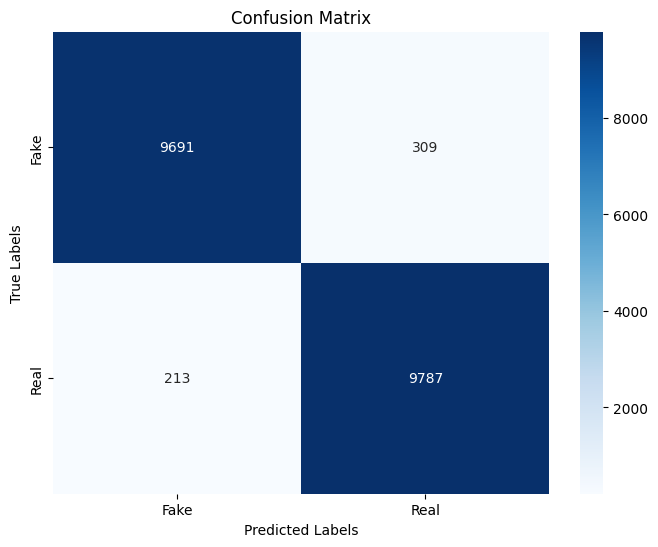

Accuracy: 0.9739
F1 Score: 0.9739
Precision: 0.9694
Recall: 0.9787
ROC AUC: 0.9967

Classification report:

              precision    recall  f1-score   support

        real     0.9785    0.9691    0.9738     10000
        fake     0.9694    0.9787    0.9740     10000

    accuracy                         0.9739     20000
   macro avg     0.9739    0.9739    0.9739     20000
weighted avg     0.9739    0.9739    0.9739     20000



In [24]:
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_classes)
f1 = f1_score(true_labels, predicted_classes, average='macro')
precision = precision_score(true_labels, predicted_classes)
recall = recall_score(true_labels, predicted_classes)
roc_auc = roc_auc_score(true_labels, predictions.predictions[:, 1])

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(true_labels, predicted_classes, target_names=labels_list, digits=4))

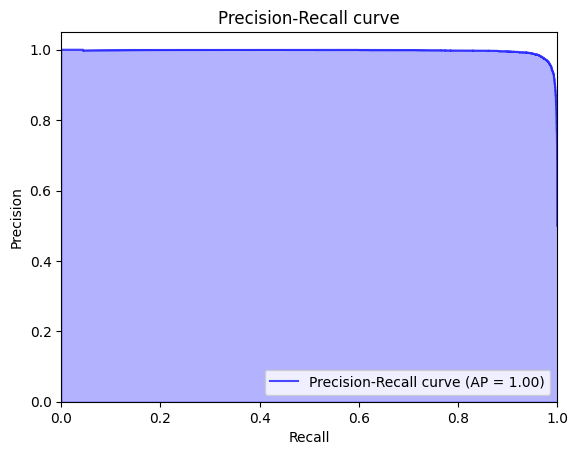

In [25]:
precision, recall, _ = precision_recall_curve(true_labels, predictions.predictions[:, 1])
average_precision = average_precision_score(true_labels, predictions.predictions[:, 1])

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

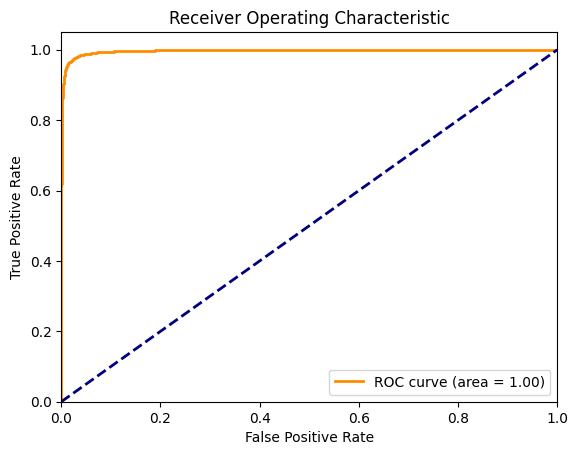

In [26]:
fpr, tpr, _ = roc_curve(true_labels, predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()